In [1]:
# Carga de librerías 
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

In [2]:
# Montamos el directorio Drive para obtener las imágenes
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Parámetros de las imágenes
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 29
TRAIN_DIR = "/content/gdrive/MyDrive/Backup/DATCOM/AA/Sentinel2LULC_354/Sentinel2LULC_354/"
TEST_DIR = "/content/gdrive/MyDrive/Backup/DATCOM/AA/Test 2"

# Parámetros de entrenamiento
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 0.001 # default
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy', 'AUC']

In [4]:
# Leemos las imágenes de entrenamiento y las dividimos en 80% para entrenamiento
# del modelo y 20% para validación 
train_datagenerator = ImageDataGenerator(rescale=1/255, 
                                         validation_split=0.2,
                                         rotation_range=45,
                                         width_shift_range=.15,
                                         height_shift_range=.15,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range=0.5)
train_it = train_datagenerator.flow_from_directory(directory=TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    subset='training')
validation_it = train_datagenerator.flow_from_directory(directory=TRAIN_DIR,
                                                        target_size=(HEIGHT, WIDTH),
                                                        class_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        subset='validation')

Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.


In [5]:
# Cargamos el modelo Xception con los pesos de haber sido enterenado con ImageNET
base_model = Xception(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, CHANNELS))
print("Nº de capas: ", len(base_model.layers))

Nº de capas:  132


In [ ]:
# PRIMERA VERSIÓN: sin re-entrenar ninguna capa
base_model.trainable = False

In [6]:
# SEGUNDA VERSIÓN: finetuning re-entrenando algunas capas
base_model.trainable = True
# Número de capas a re-entrenar
fine_tune_at = 50
# Congelamos los pesos de todas las capas anteriores a las que se van a re-entrenar
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [7]:
# Adaptamos el modelo a nuestro problema
input_layer = Input(shape=(HEIGHT, WIDTH, CHANNELS), name='input_image')
output_conv = base_model(input_layer)
x = Flatten(name='flatten')(output_conv) 
x = Dense(N_CLASSES, activation='softmax', name='classes')(x)
model = Model(inputs=input_layer, outputs=x)
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss=LOSS, metrics=METRICS)
history = model.fit(train_it,
          validation_data=validation_it,
          steps_per_epoch=train_it.n // BATCH_SIZE,
          validation_steps=validation_it.n // BATCH_SIZE,
          epochs=EPOCHS,
          workers=100,
          use_multiprocessing=True)
# Guardamos el modelo en un fichero
model_filename = "xception_model_data_augmentation.h5"
model.save(model_filename)

Epoch 1/25
128/128 [==============================] - 234s 2s/step - loss: 2.2654 - accuracy: 0.3254 - auc: 0.8686 - val_loss: 1.9038 - val_accuracy: 0.4632 - val_auc: 0.9243
Epoch 2/25
128/128 [==============================] - 165s 1s/step - loss: 0.9695 - accuracy: 0.6736 - auc: 0.9789 - val_loss: 2.1685 - val_accuracy: 0.5423 - val_auc: 0.9094
Epoch 3/25
128/128 [==============================] - 163s 1s/step - loss: 0.7806 - accuracy: 0.7391 - auc: 0.9849 - val_loss: 1.0030 - val_accuracy: 0.6719 - val_auc: 0.9734
Epoch 4/25
128/128 [==============================] - 162s 1s/step - loss: 0.6555 - accuracy: 0.7753 - auc: 0.9887 - val_loss: 1.0312 - val_accuracy: 0.7011 - val_auc: 0.9661
Epoch 5/25
128/128 [==============================] - 164s 1s/step - loss: 0.5389 - accuracy: 0.8105 - auc: 0.9919 - val_loss: 0.9767 - val_accuracy: 0.7157 - val_auc: 0.9692
Epoch 6/25
128/128 [==============================] - 166s 1s/step - loss: 0.5436 - accuracy: 0.8147 - auc: 0.9911 - val_loss

In [8]:
# Cargamos las imágenes de test
test_datagenerator = ImageDataGenerator(rescale=1./255)
test_it = test_datagenerator.flow_from_directory(directory=TEST_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size= 1,
                                                  class_mode=None,
                                                  shuffle=False)
# Reseteamos el iterador sobre las imágenes de test
test_it.reset()

# Predecimos con el modelo entrenado sobre las imágenes de test
test_probs = model.predict(test_it, steps=test_it.samples)
test_preds = np.argmax(test_probs, axis=1)
print("\nPredicciones: ", test_preds)

# Construimos un traductor entre las etiquetas automáticamente generadas por Keras
# y las reales a partir de los nombres de las carpetas de entrenamiento
translated_train_labels = {train_it.class_indices[key]:int(key[:key.index("_")]) 
                        for key in train_it.class_indices}
print("\nEtiquetas train: ", translated_train_labels)

# Traducimos las etiquetas de test resultantes a las reales
translated_test_preds = [translated_train_labels[label] for label in test_preds]
print("\nPredicciones reales: ", translated_test_preds)

# Creamos el fichero de subida
id_jpg_column = [test_img[(test_img.find("/") + 1): ] for test_img in test_it.filenames]
preds_dataset = pd.DataFrame({'id.jpg': id_jpg_column, 'label': translated_test_preds})
preds_filename = "submission_xception_data_aug.csv"
preds_dataset.to_csv(preds_filename, index=False)

Found 1618 images belonging to 1 classes.

Predicciones:  [ 0  2  0 ... 28 28  5]

Etiquetas train:  {0: 10, 1: 11, 2: 12, 3: 13, 4: 14, 5: 15, 6: 16, 7: 17, 8: 18, 9: 19, 10: 1, 11: 20, 12: 21, 13: 22, 14: 23, 15: 24, 16: 25, 17: 26, 18: 27, 19: 28, 20: 29, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 28: 9}

Predicciones reales:  [10, 12, 10, 10, 10, 11, 12, 10, 12, 11, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 11, 6, 10, 10, 10, 10, 22, 11, 11, 11, 11, 11, 11, 11, 14, 11, 11, 10, 11, 11, 11, 14, 11, 11, 11, 11, 11, 11, 17, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 14, 11, 11, 11, 11, 11, 14, 14, 11, 11, 11, 14, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13

Text(0.5, 1.0, 'Training and Validation Accuracy')

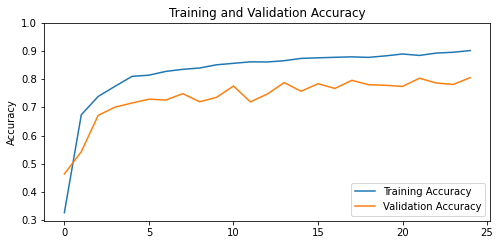

In [9]:
# Gráfica de la evolución de entrenamiento y validación durante las épocas
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')